In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D,MaxPooling2D,BatchNormalization,
                                     Conv2DTranspose,UpSampling2D,Concatenate,Dropout)
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
cd = Path.cwd()
folder_path = os.path.join(cd,r'OneDrive\Desktop\Datasets\blood-vessel-segmentation')
images_path = os.path.join(folder_path,'downsized-images')
height = 512
width = 512

def extract_image(path,dtype=tf.float32,is_mask=False):
    
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image)
    image = tf.image.convert_image_dtype(image,dtype)
    if is_mask:
        image = tf.round(image)
        
    return image

In [3]:
all_kidney_folders = [os.path.join(images_path,f) for f in os.listdir(images_path)]

def images_and_masks(folder):
    
    images_path = os.path.join(folder,'images')
    masks_path = os.path.join(folder,'labels')
    all_images_paths = [os.path.join(images_path,p) for p in os.listdir(images_path)]
    all_masks_paths = [os.path.join(masks_path,p) for p in os.listdir(masks_path)]
    
    return all_images_paths,all_masks_paths

#### The cell below organizes the paths to all the data. The data consist of images of cross sections of kidneys and the corresponding segmentation masks of their vasculature (i.e. location of blood vessels.) There are a total of 7,429 image-mask pairs that come from three different kidneys.
#### Each image is 512x512 pixels with values between 0 and 1 and each mask is 512x512 with each pixels being either 0 or 1 (1 corresponds to the location of a blood vessel.)

In [4]:
kidney1_dense_images,kidney1_dense_masks = images_and_masks(all_kidney_folders[0])

kidney1_voi_images,kidney1_voi_masks = images_and_masks(all_kidney_folders[1])

kidney2_images,kidney2_masks = images_and_masks(all_kidney_folders[2])

kidney3_dense_masks_path = os.path.join(all_kidney_folders[3],'labels')
kidney3_dense_masks = [os.path.join(kidney3_dense_masks_path,p) for p in os.listdir(kidney3_dense_masks_path)]

kidney3_sparse_images,kidney3_sparse_masks = images_and_masks(all_kidney_folders[4])

kidney3_dense_images = []

for p in kidney3_dense_masks:
    image_path = p.replace('dense','sparse').replace('labels','images')
    kidney3_dense_images.append(image_path)
    
all_images = kidney1_dense_images + kidney1_voi_images + kidney2_images + kidney3_sparse_images + kidney3_dense_images
all_masks = kidney1_dense_masks + kidney1_voi_masks + kidney2_masks + kidney3_sparse_masks + kidney3_dense_masks


train_images,test_images,train_masks,test_masks = train_test_split(all_images,
                                                                  all_masks,
                                                                  test_size=.03,
                                                                  random_state=12)

print('There are {} images in the train set and {} images in the test set.'.format(len(train_images),
                                                                                   len(test_images)))

There are 7206 images in the train set and 223 images in the test set.


#### Here are some examples of what the data looks like. On the left are the images of cross sections of kidneys and the segmentation masks are on the right.The highlighted area in the segmentation mask corresponds to a labeled blood vessel in the image to its left:

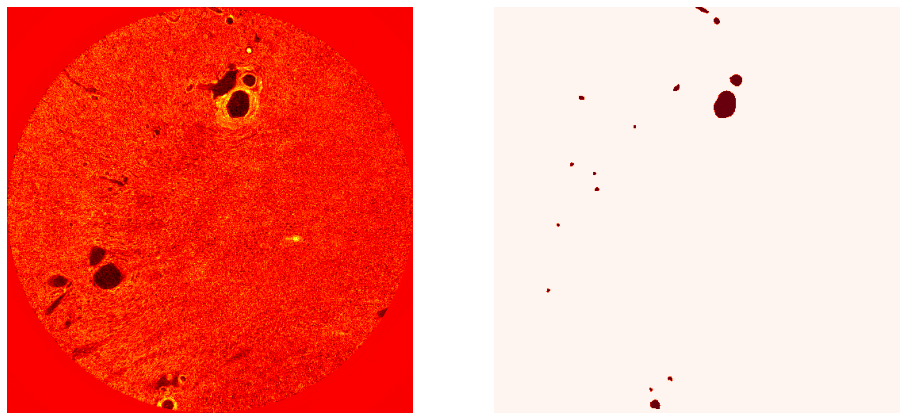

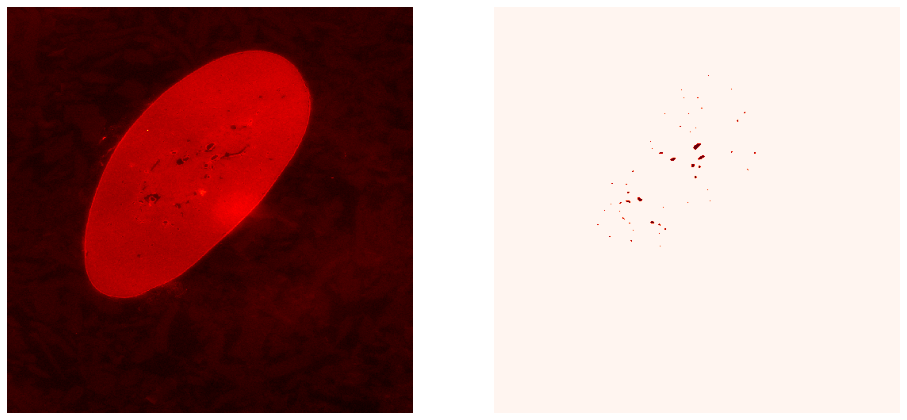

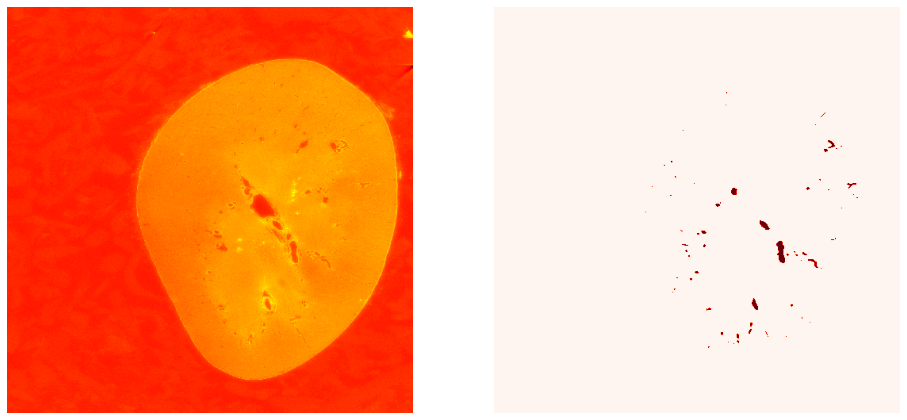

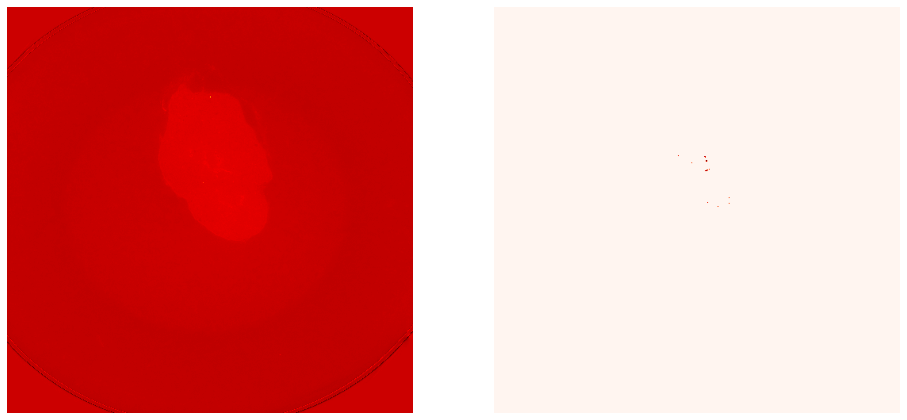

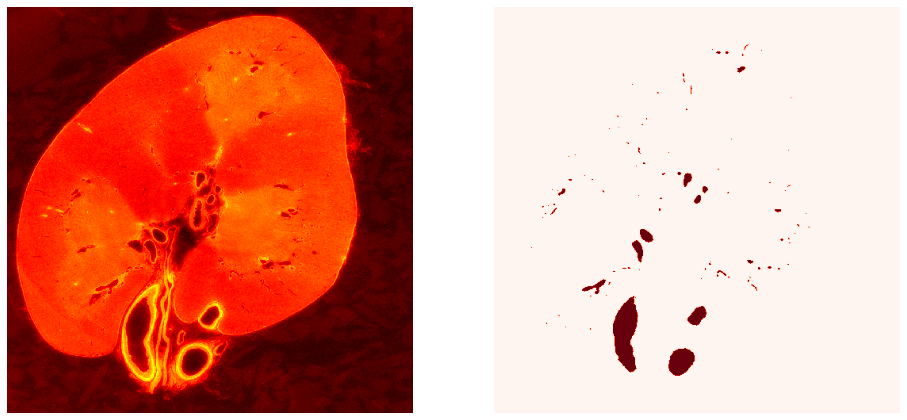

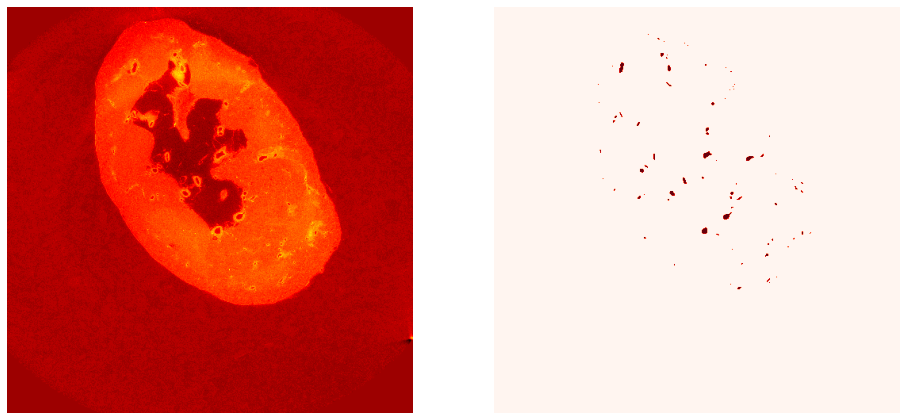

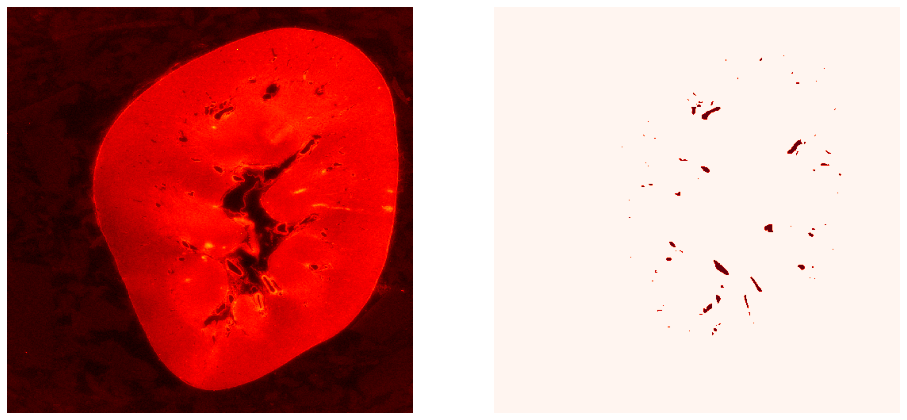

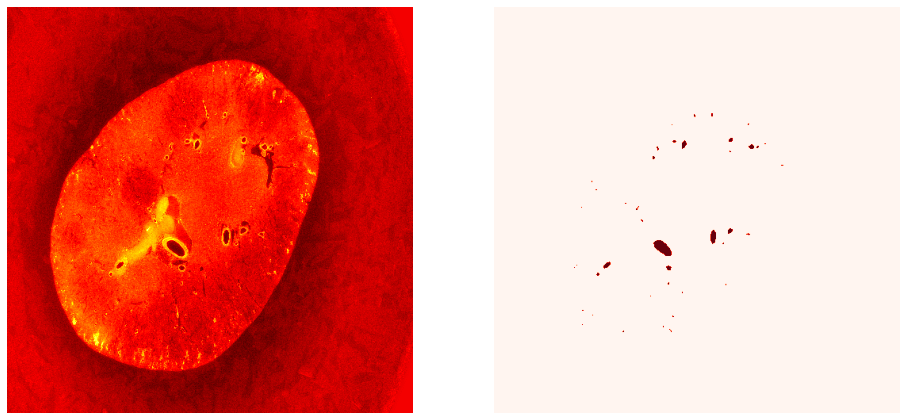

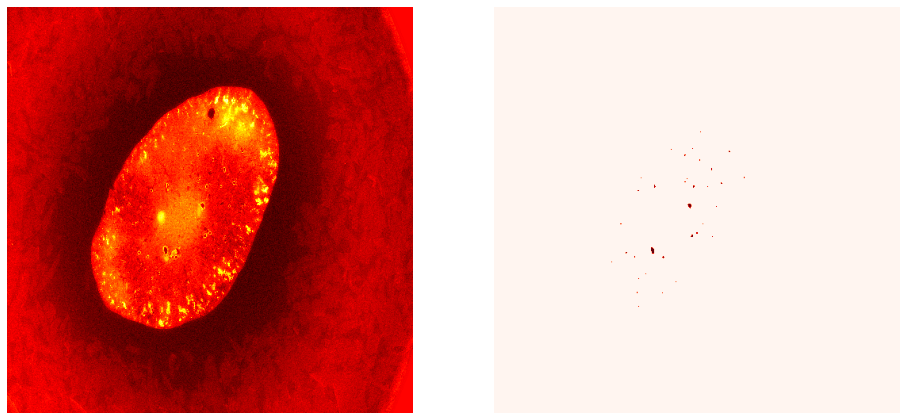

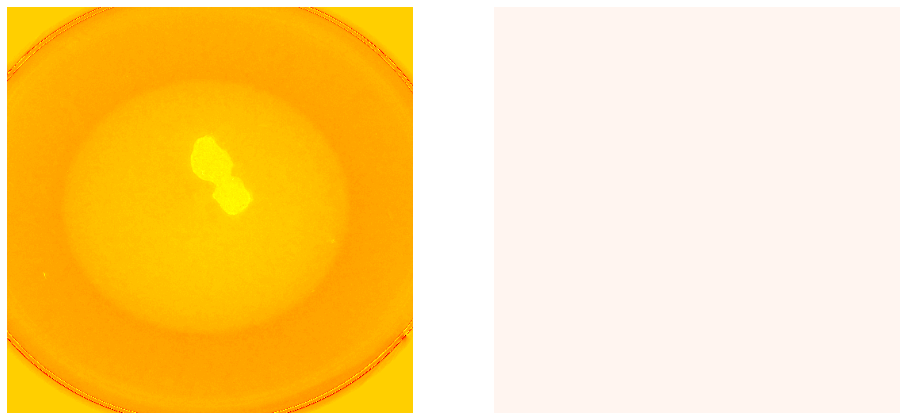

In [5]:
for i in range(10):
    n = random.randint(0,len(all_images)-1)
    image = extract_image(all_images[n])
    mask = extract_image(all_masks[n],is_mask=True)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(image,cmap='hot')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap='Reds')
    plt.axis('off')
    plt.show()

#### The data is fed into the model in batches of 24 image-mask pairs. The train data is randomly flipped both horizontally and vertically to reduce overfitting.

In [6]:
def random_flip(x,y):

    if tf.random.categorical(logits=tf.math.log([[.5,.5]]),num_samples=1) == 1:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)
    if tf.random.categorical(logits=tf.math.log([[.5,.5]]),num_samples=1) == 1:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)
    return x,y


batch_size = 24
def make_dataset(images,masks,train=True):

    dataset = tf.data.Dataset.from_tensor_slices((images,masks))
    dataset = dataset.map(lambda x,y: (extract_image(x),extract_image(y,is_mask=True)))
    if train:
        dataset = dataset.map(random_flip).shuffle(batch_size*10)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
train_dataset = make_dataset(train_images,train_masks)
test_dataset = make_dataset(test_images,test_masks,train=False)

#### The following two functions create the bulk of the model. The first uses a convolutional layer and max pooling layer to reduce dimensionality, returning the output of the max pooling to move forward in the model and the output of the convolution to save for later.
#### The second function uses convolutional transpose and upsampling layers to increase the dimensionality in order to achieve the desired output size (which is the same size as the input.) It also accepts as an argument an earlier saved layer that it concatenates with the output of the upsampling.
#### Both functions use batch normalization and dropout layers.

In [8]:
dropout_rate = .2

def conv_block(X,filters,filter_size=3):

    X = Conv2D(filters,filter_size,activation='relu')(X)
    save_layer = BatchNormalization()(X)
    X = MaxPooling2D(2,2)(save_layer)
    X = Dropout(dropout_rate)(X)

    return save_layer,X


def conv_transpose_block(X,filters,kernel_size,saved_layer_index,add_to_filter=0):

    X = Conv2DTranspose(filters,kernel_size,activation='relu')(X)
    X = UpSampling2D(2)(X)
    X = Conv2D(filters,1,activation='selu')(X)
    if add_to_filter > 0:
        X = Conv2DTranspose(filters,add_to_filter+1,activation='relu')(X)
    X = Concatenate()([X,saved_layers[saved_layer_index]])
    X = BatchNormalization()(X)
    X = Dropout(dropout_rate)(X)

    return X

#### The customized loss function creates a weighted loss that first takes the binary crossentropy between the true and predicted labels, and then takes the loss only at the points where there the true label is 1 (i.e. a pixel is labeled as part of a blood vessel), multiplies it by a number (I chose 64), and adds it to the original loss. This prevents the model from relying on outputting only zeros, which greatly outnumber the ones.

In [9]:
class WeightedLoss(keras.losses.Loss):

    def __init__(self,weight):
        super(WeightedLoss,self).__init__()
        self.weight = weight
        self.bce = keras.losses.BinaryCrossentropy()

    def call(self,y_true,y_pred):

        loss = self.bce(y_true,y_pred)
        masked_y_pred = y_true * y_pred
        loss += self.bce(y_true,masked_y_pred) * self.weight

        return loss
    
weighted_loss = WeightedLoss(64)

#### The model uses a u-net architecture, which decreases the vertical and horizontal dimensionality while increasing the depth, saving layers as it decreases, and then increases the vertical/horizontal dimensionality as the depth decreases, concatenating saved layers from earlier in the model.

In [10]:
filters = 24

inputs = keras.Input(shape=(height,width,1))
X = inputs

saved_layers = []
for i in range(7):
    save_layer,X = conv_block(X,filters)
    saved_layers.append(save_layer)
    filters *= 2

filters /= 2
X = Conv2D(filters,2,activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(dropout_rate)(X)

for i in range(7):
    kernel_size = 3 if i > 0 else 2
    saved_layer_index = len(saved_layers) - i - 1
    add_to_filter = 0 if i != 5 else 1
    X = conv_transpose_block(X,filters,kernel_size,saved_layer_index,add_to_filter)
    filters /= 2

filters *= 2
X = Conv2DTranspose(filters,3,activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(dropout_rate)(X)

for i in range(2):
    X = Conv2D(filters,1,activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout_rate)(X)

outputs = Conv2D(1,1,activation='sigmoid')(X)

model = keras.Model(inputs=inputs,
                   outputs=outputs)

optimizer = keras.optimizers.Adam(1e-4)
model.compile(loss=weighted_loss,
             optimizer=optimizer,
             metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.Recall()
                ])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 510, 510, 24  240         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 510, 510, 24  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#### The model was trained on a GPU and the weights were downloaded and uploaded here. Below you can see the metrics of the model's performace on a subset of the train data and the entirety of the test data. The metrics are loss (as described earlier), accuracy, and recall.

In [11]:
weights_path = os.path.join(folder_path,'blood-vessel-model-weights.h5')
model.load_weights(weights_path)

train_metrics = model.evaluate(train_dataset.take(5),verbose=0)
test_metrics = model.evaluate(test_dataset,verbose=0)

train_metrics = [round(n,4) for n in train_metrics]
test_metrics = [round(n,4) for n in test_metrics]
for i in range(1,3):
    train_metrics[i] = str(train_metrics[i]*100)[:5] + '%' 
    test_metrics[i] = str(test_metrics[i]*100)[:5] + '%'

metrics_dict = {'Train':train_metrics,'Test':test_metrics}
metrics = ['Loss','Accuracy','Recall']
metrics_df = pd.DataFrame(metrics_dict,index=metrics)
metrics_df

Train    Test
Loss      0.0123  0.0128
Accuracy  99.79%  99.78%
Recall    99.48%  99.42%

#### Here are examples of the model's performance on train images; for each example the image, the correct mask as per the label, and the predicted mask created by the model are shown:

               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


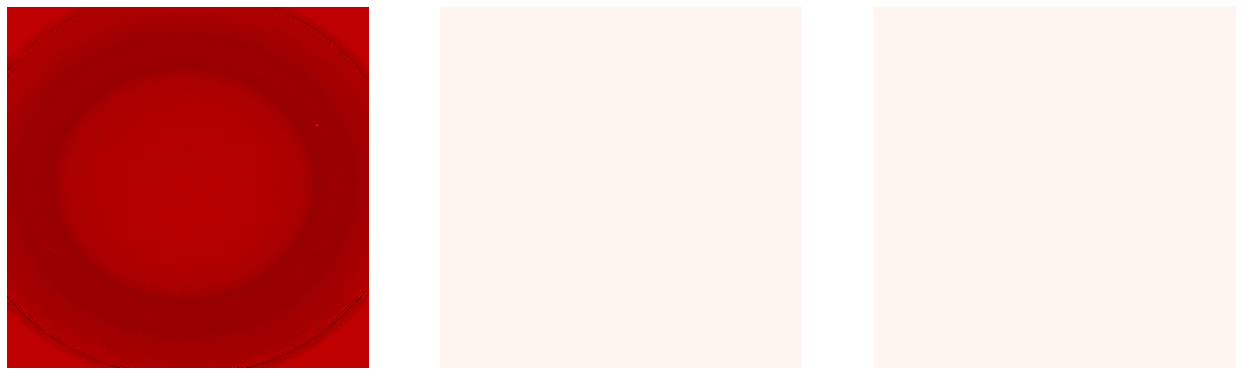


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


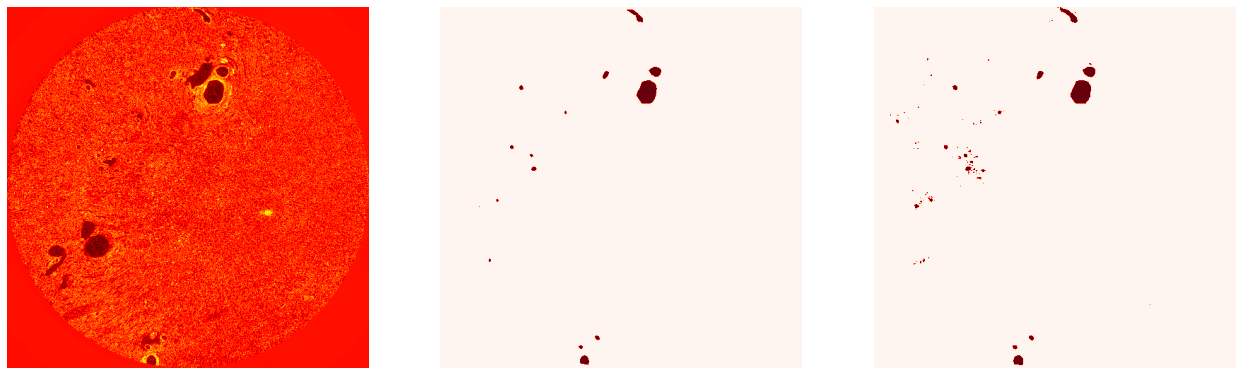


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


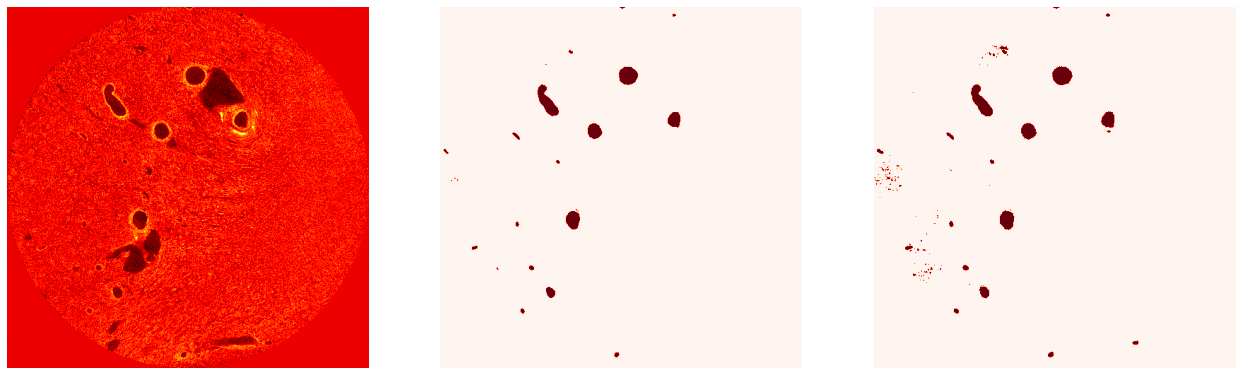


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


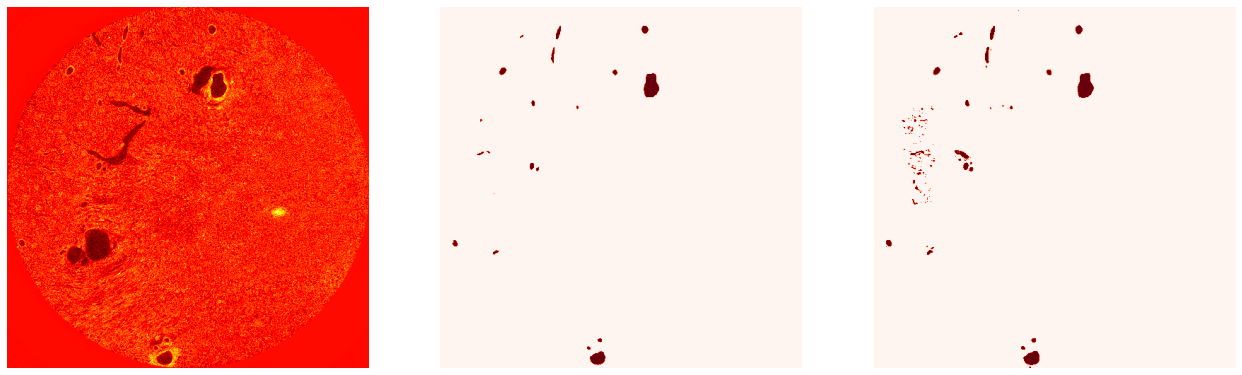


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


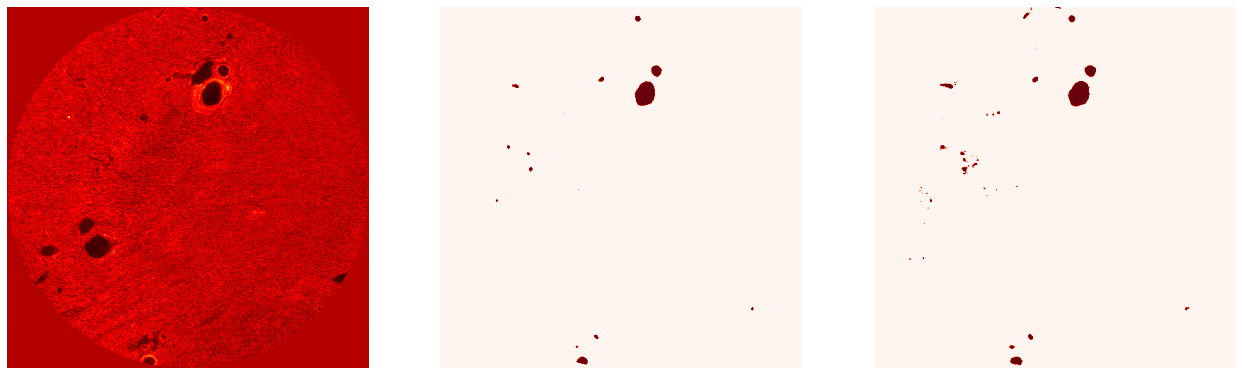

In [12]:
num_examples = 5

examples = random.sample(range(len(train_images)),num_examples)

images = np.array([extract_image(train_images[i]) for i in examples])
masks = [extract_image(train_masks[i],is_mask=True) for i in examples]

predicted_masks = model.predict(images,verbose=0).round()

for i in range(num_examples):
    print('{}IMAGE:{}TRUE MASK:{}PREDICTED MASK:'.format(' '*15,' '*35,' '*32))
    plt.figure(figsize=(22,12))
    plt.subplot(1,3,1)
    plt.imshow(images[i],cmap="hot")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks[i],cmap='Reds')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predicted_masks[i],cmap='Reds')
    plt.axis('off')
    plt.show()
    print()

#### Here are examples of the model's performace on test images:

               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


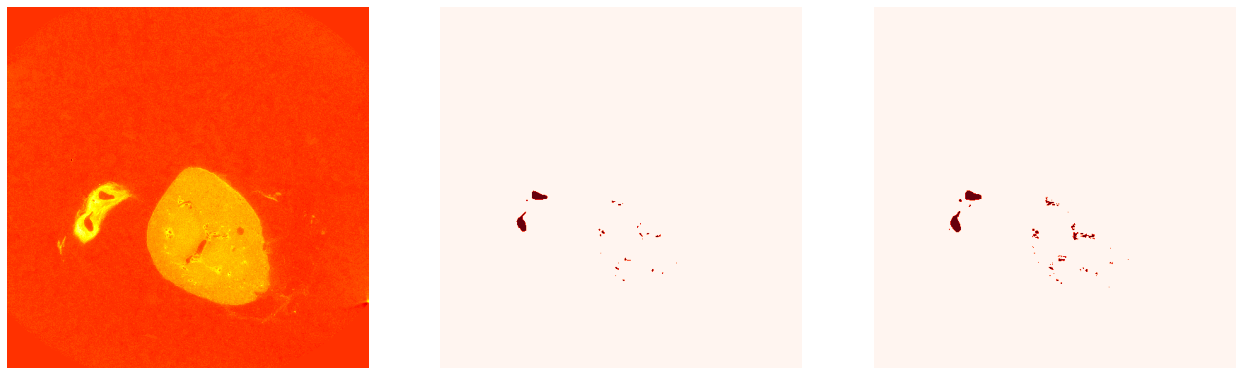


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


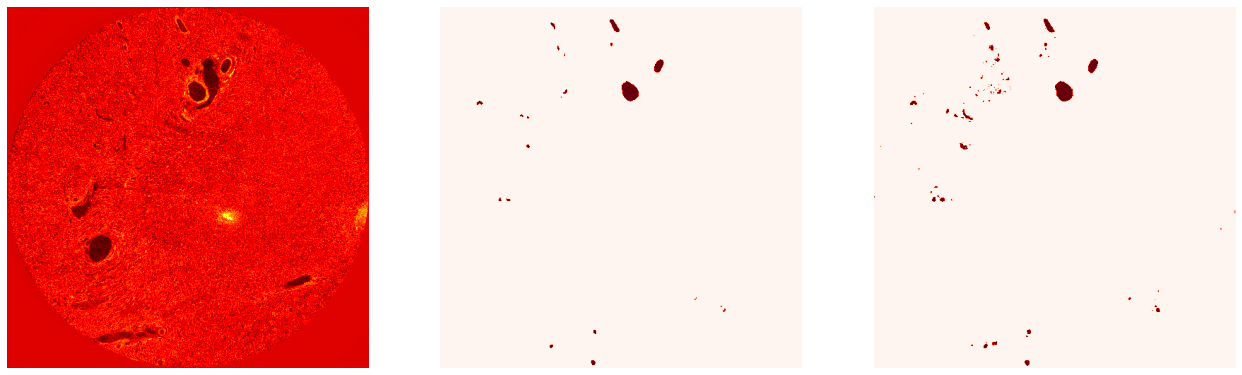


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


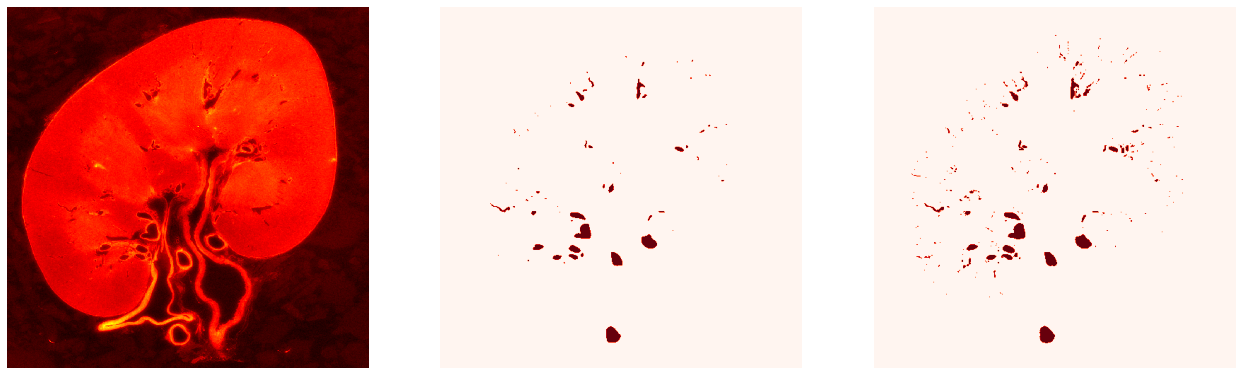


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


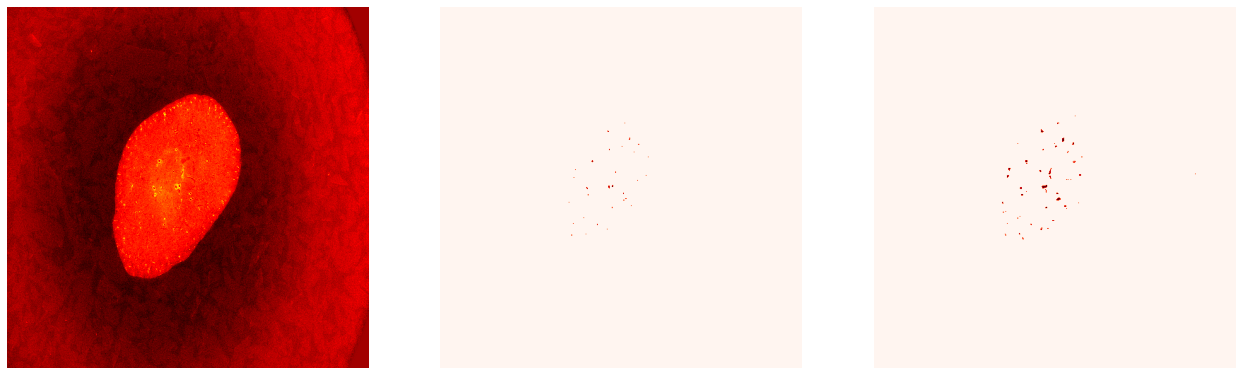


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


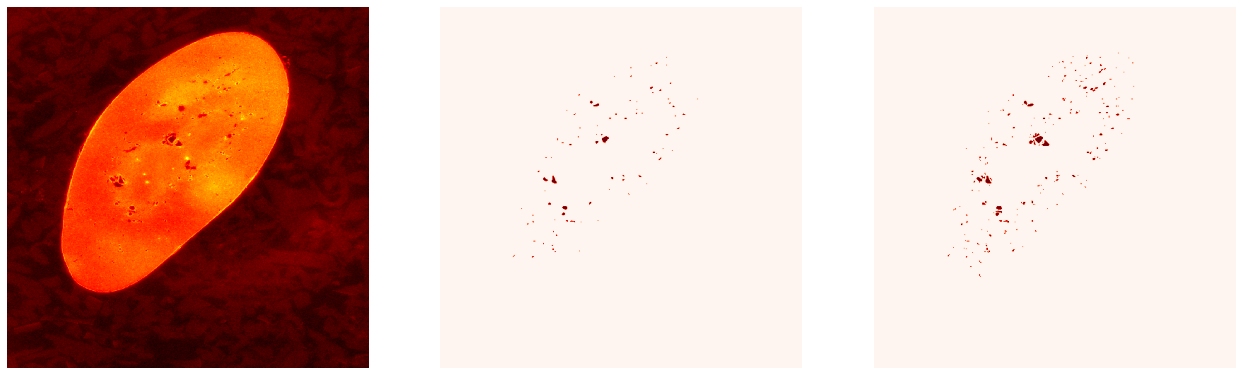


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


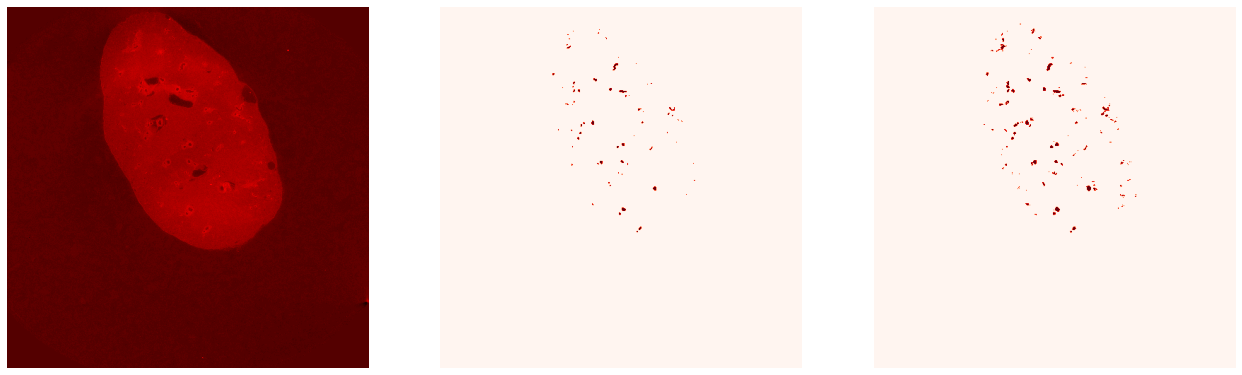


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


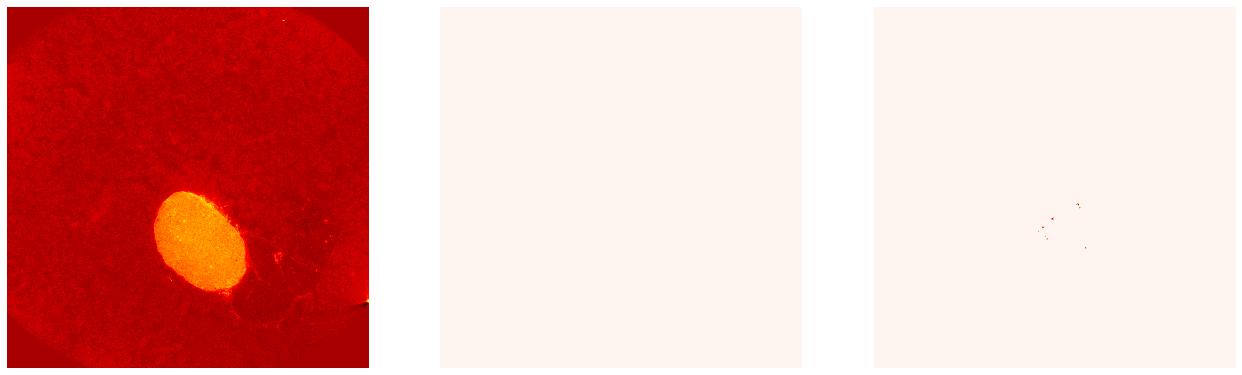


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


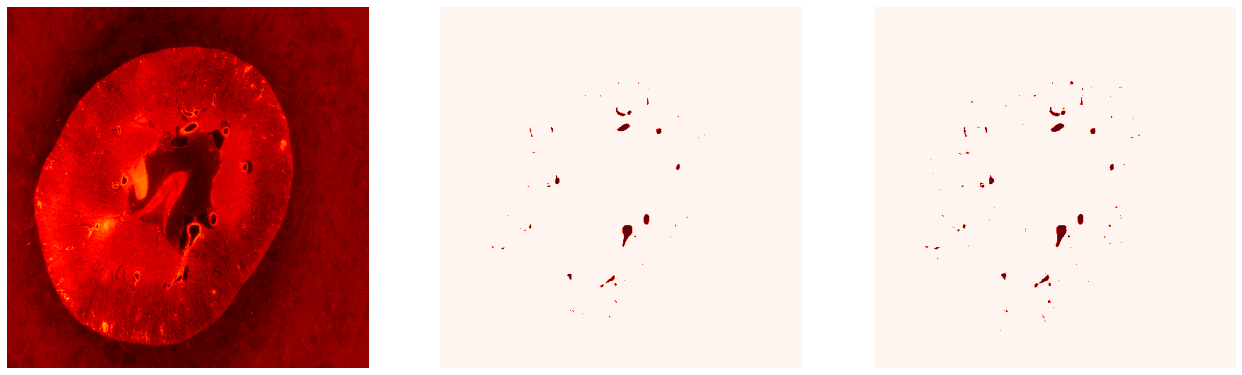


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


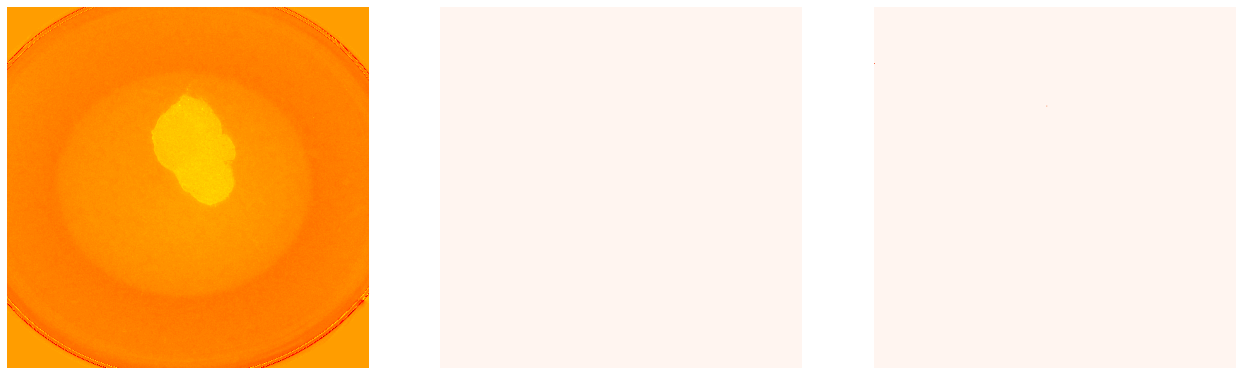


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


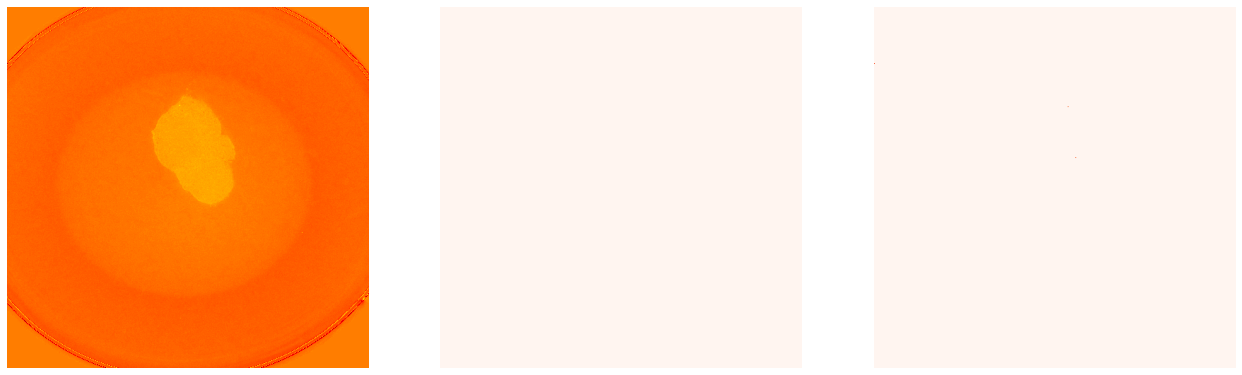


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


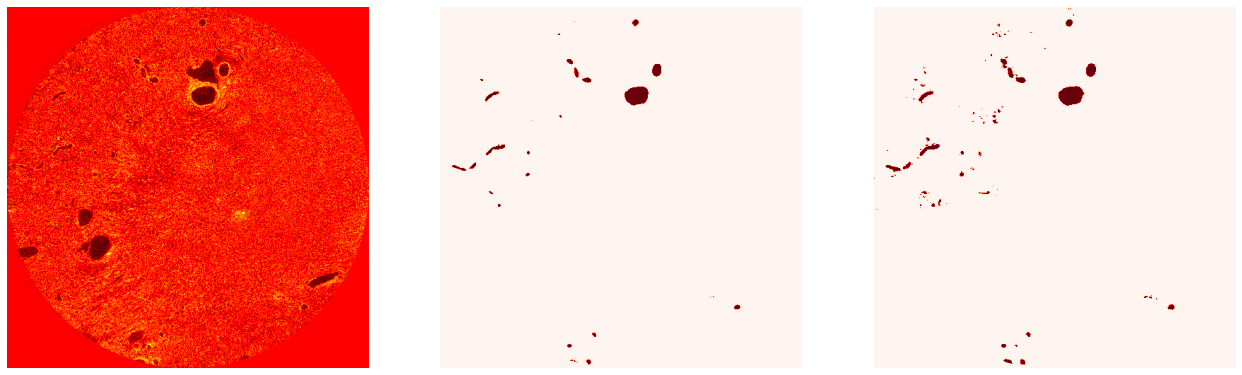


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


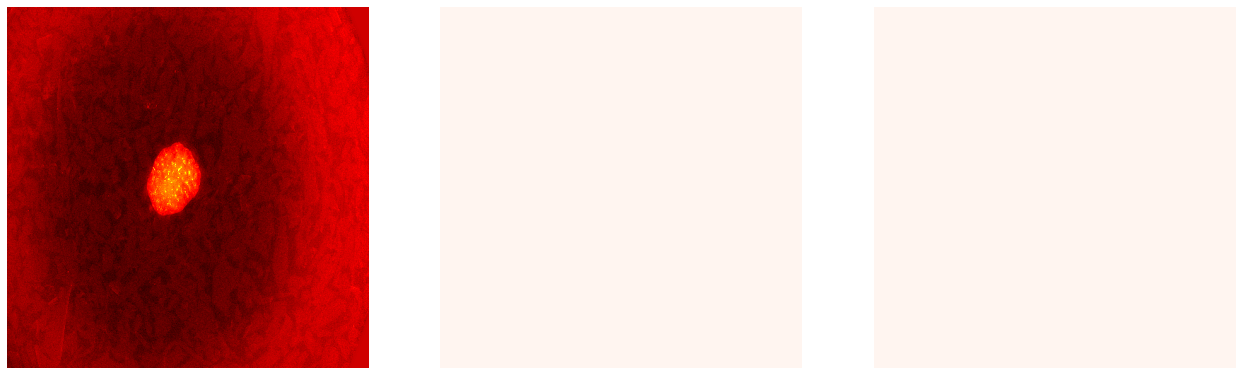


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


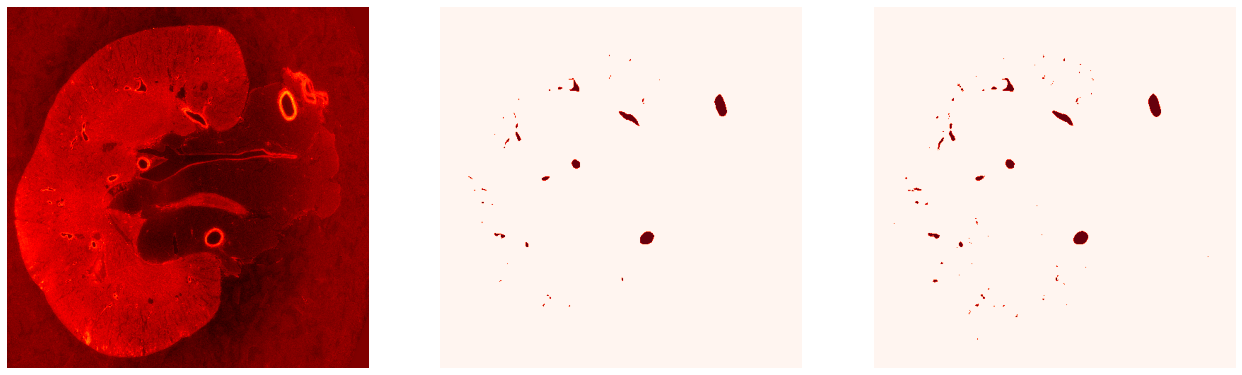


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


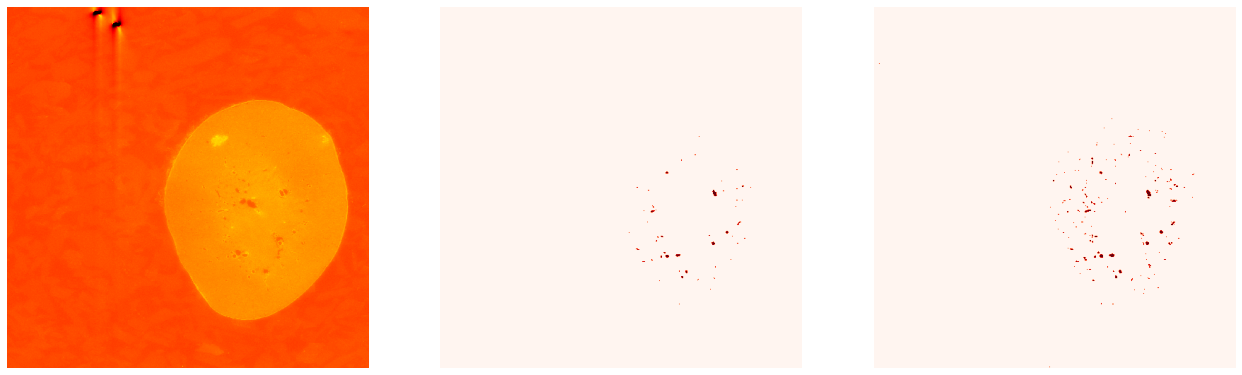


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


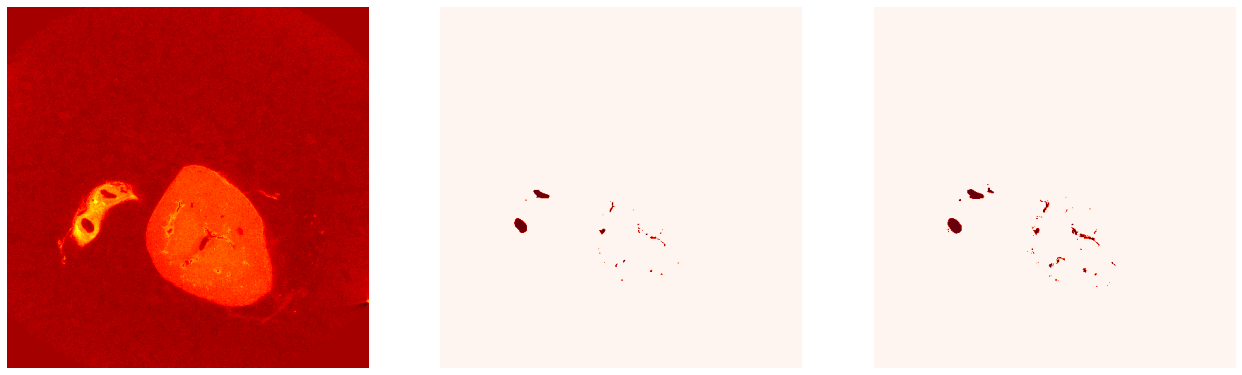


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


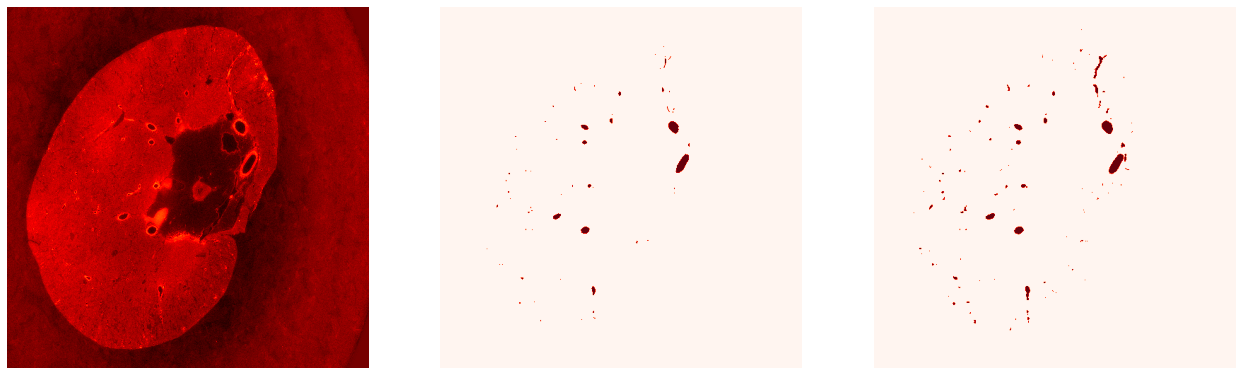


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


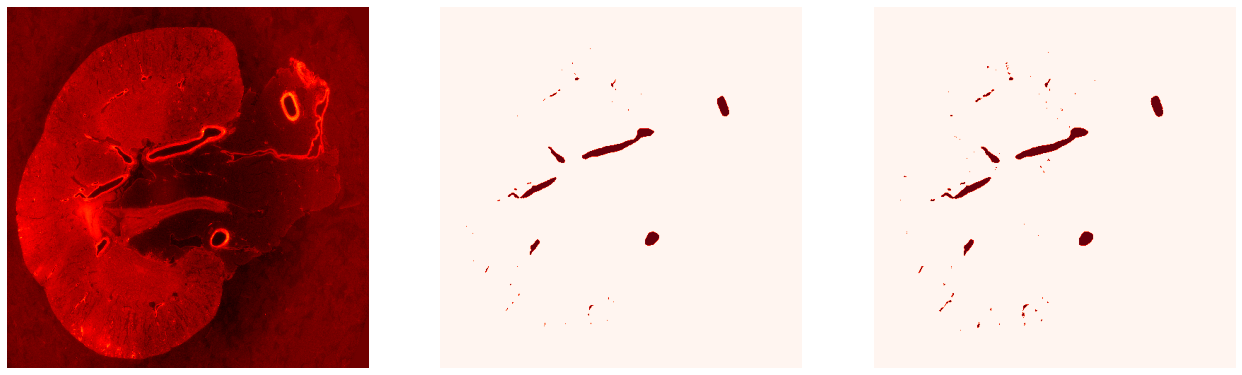


               IMAGE:                                   TRUE MASK:                                PREDICTED MASK:


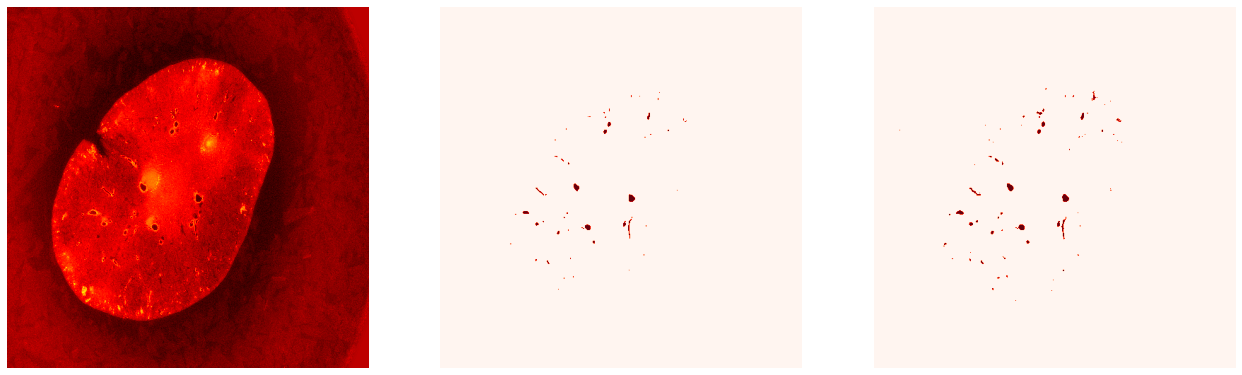

In [13]:
num_examples = 18

examples = random.sample(range(len(test_images)),num_examples)

images = np.array([extract_image(test_images[i]) for i in examples])
masks = [extract_image(test_masks[i],is_mask=True) for i in examples]

predicted_masks = model.predict(images,verbose=0).round()

for i in range(num_examples):
    print('{}IMAGE:{}TRUE MASK:{}PREDICTED MASK:'.format(' '*15,' '*35,' '*32))
    plt.figure(figsize=(22,12))
    plt.subplot(1,3,1)
    plt.imshow(images[i],cmap="hot")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks[i],cmap='Reds')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predicted_masks[i],cmap='Reds')
    plt.axis('off')
    plt.show()
    print()